In [1]:
import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap

from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


- Each trial is characterized by a particle moving clockwise on a circle, starting at a different random phase in each trial
- Each neuron has a "preferred angle" around which its response function falls off according to some tuning curve f(•) with cyclic boundary conditions i.e., f(2 $\pi$) = f(0)
    -  If the particle is at position $\theta$ and the preferred position of neuron i is $\theta_{i}$, then the neuron's response is f($\theta$-$\theta_{i}$).

To generate a K x T x N dataset, do:
- random phases: phi = 2* $\pi$ *jnp.uniform_random_01().reshape((K, 1, 1))
- neuron's preferred directions: thetas = jnp.linspace(0,2*pi, size=(1,1,N))
- time measured in radians : time = jnp.linspace(0, some_fraction_of*2*pi, size=(1,T,1))

--> dataset = f(thetas-time+phi) ; with f(•) = exp((cos(•)-1)/kappa); kappa is the width of the tuning curve.






In [17]:
seed = 42
key = random.PRNGKey(seed)
key1, key2 = random.split(key, 2)

K, T, N = 40, 50, 50
split = 10
c = 30
d = 2
dropout_rate = 0.1

def f_(x, kappa=1):
    return jnp.exp( (jnp.cos(x)-1) / kappa )            #Von Mises tuning curve 

phi = 2*jnp.pi * random.uniform(key1, (K,))[:, jnp.newaxis, jnp.newaxis] 
thetas = jnp.linspace(0, 2 *jnp.pi, N)[jnp.newaxis, jnp.newaxis, :] 
time = jnp.linspace(0, 2*jnp.pi, T)[jnp.newaxis, :, jnp.newaxis] 

X = f_(thetas-time+phi, kappa = 1).swapaxes(1,2)

mask = random.bernoulli(key2, 1.0 - dropout_rate, (K, N, T))
X *= mask

X_train=X[split:]
X_test=X[:split]
A = jnp.swapaxes(X_train, 0, 1)          
A = A.reshape(N,-1)   

Iteration 0, S: 0.33292126655578613, S_ratio: 0.7024036645889282
Iteration 10, S: 15.359182357788086, S_ratio: 0.9636222720146179
Iteration 20, S: 71.07415008544922, S_ratio: 0.9631945490837097
Iteration 30, S: 127.58819580078125, S_ratio: 0.9487457275390625
Iteration 40, S: 160.87889099121094, S_ratio: 0.9245550036430359
Iteration 50, S: 177.24063110351562, S_ratio: 0.9640746712684631
Iteration 60, S: 182.71400451660156, S_ratio: 0.9814637303352356
Iteration 70, S: 184.01792907714844, S_ratio: 0.8982245922088623
Iteration 80, S: 176.53900146484375, S_ratio: 0.955131471157074
Iteration 90, S: 175.0073699951172, S_ratio: 0.9272968769073486
Iteration 100, S: 175.0863037109375, S_ratio: 0.9126331806182861
Iteration 110, S: 181.0015106201172, S_ratio: 1.0031638145446777
Iteration 120, S: 183.0935821533203, S_ratio: 0.915937066078186
Iteration 130, S: 184.55406188964844, S_ratio: 0.8725848197937012
Iteration 140, S: 182.7036895751953, S_ratio: 0.9707951545715332
Iteration 150, S: 180.531585

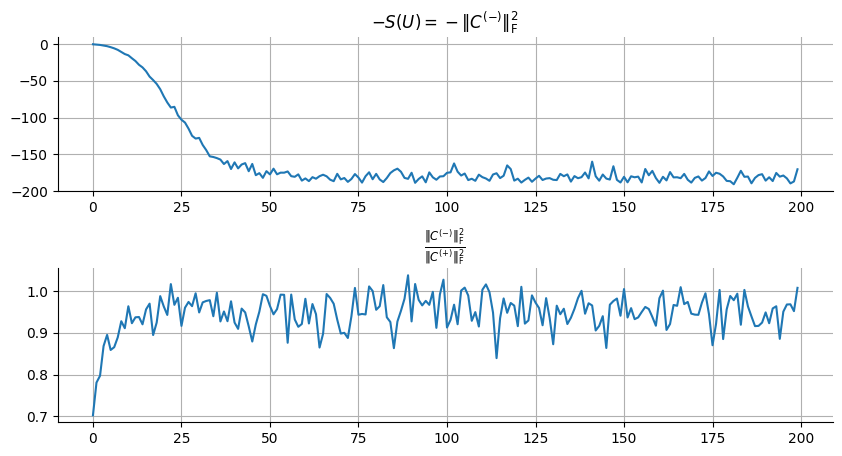

In [18]:
kernel_function=K_X_Y_squared_exponential

from kernel_sca_inducing_points import *
wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X_train, A, iterations=200, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

get_loss_fig(ls_loss, ls_S_ratio )

0.054573853


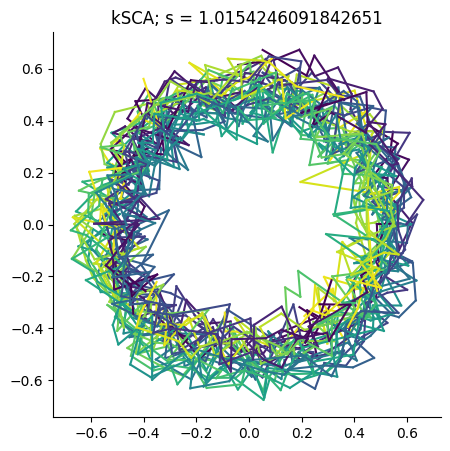

<Figure size 640x480 with 0 Axes>

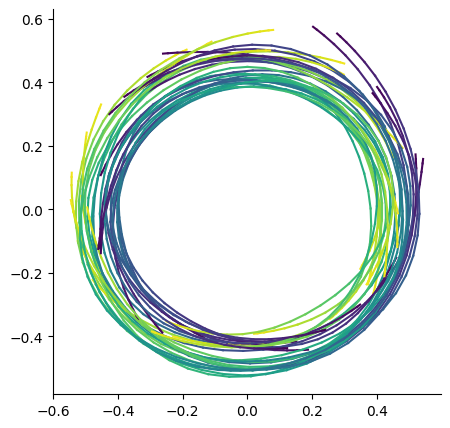

In [20]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, _, _, _  = get_alpha(params, A, X_train, kernel_function, d)

K, N, T = X_train.shape
X_reshaped = X_train.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

plot_2D(Y[:,:,:])
plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

Y_smoothed = apply_gaussian_smoothing(Y, sigma=4)
plt.figure()
plot_2D(Y_smoothed)

X_reshaped = X.swapaxes(1,2).reshape(-1, N)
full_X_var = jnp.sum(jnp.var(X_reshaped, axis=0))

Y_reshaped = Y.swapaxes(1,2).reshape(-1, d)
full_Y_var = jnp.sum(jnp.var(Y_reshaped, axis=0))

print( full_Y_var/full_X_var )

Iteration 0, S: 1.765012502670288, S_ratio: 0.024142861366271973
Iteration 10, S: 43.428653717041016, S_ratio: 0.38993531465530396
Iteration 20, S: 213.50262451171875, S_ratio: 0.7473508715629578
Iteration 30, S: 716.2542114257812, S_ratio: 0.836379885673523
Iteration 40, S: 1802.1533203125, S_ratio: 0.8812514543533325
Iteration 50, S: 3726.896728515625, S_ratio: 0.9048513770103455
Iteration 60, S: 6088.66015625, S_ratio: 0.915794849395752
Iteration 70, S: 9702.27734375, S_ratio: 0.9562880396842957
Iteration 80, S: 13335.455078125, S_ratio: 0.954226016998291
Iteration 90, S: 16877.369140625, S_ratio: 0.9537939429283142
Iteration 100, S: 20832.88671875, S_ratio: 0.9653661847114563
Iteration 110, S: 23077.998046875, S_ratio: 0.9672088623046875
Iteration 120, S: 25566.865234375, S_ratio: 0.8842229843139648
Iteration 130, S: 27479.66015625, S_ratio: 0.888449490070343
Iteration 140, S: 29306.673828125, S_ratio: 0.9165837168693542
Iteration 150, S: 27578.453125, S_ratio: 0.961102306842804
It

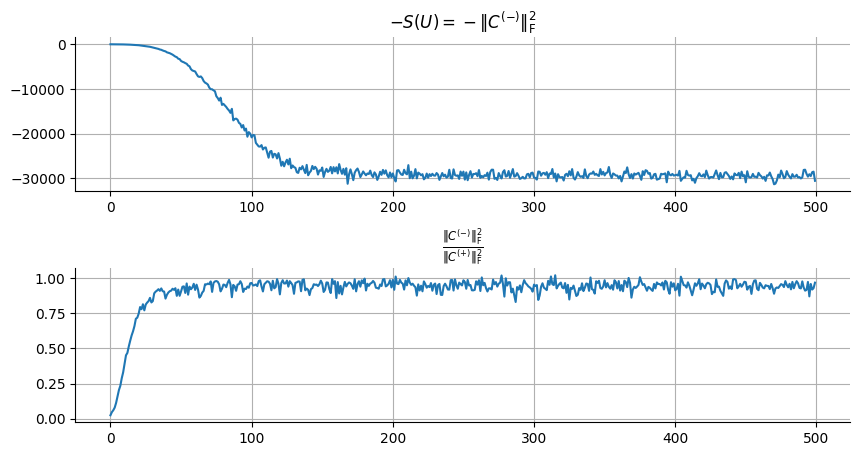

In [21]:
from linear_sca import *
wandb.init(project="", name="", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(center(X_train), d=d, learning_rate=0.01, iterations=500) 
wandb.finish

get_loss_fig(ls_loss, ls_S_ratio )


<Figure size 640x480 with 0 Axes>

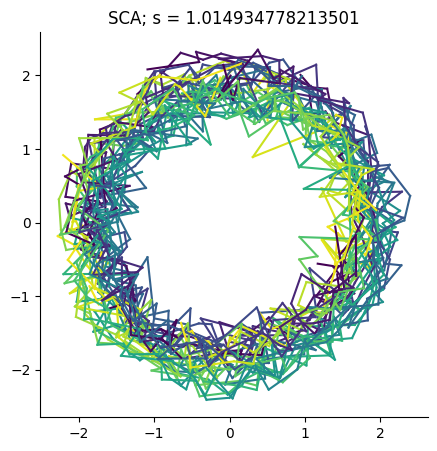

<Figure size 640x480 with 0 Axes>

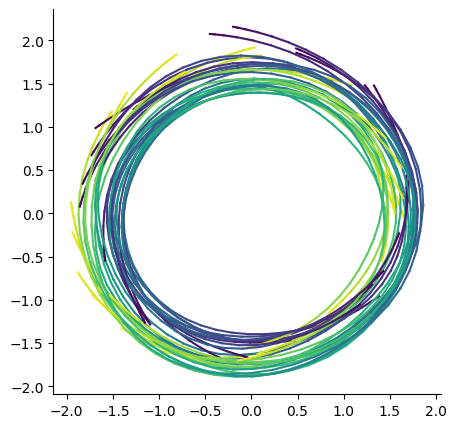

In [22]:
U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, center(X_train))

plt.figure()
plot_2D(Y[:,:,:])
plt.title(f'SCA; s = {compute_S_all_pairs(Y)}')

Y_smoothed = apply_gaussian_smoothing(Y, sigma=4)
plt.figure()
plot_2D(Y_smoothed)

In [23]:

print(var_explained(X_train, U_qr))

0.695738820028432


In [16]:
X_reshaped = X_train.swapaxes(1,2).reshape(-1, N)
full_X_var = jnp.sum(jnp.var(X_reshaped, axis=0))

Y_reshaped = Y.swapaxes(1,2).reshape(-1, d)
full_Y_var = jnp.sum(jnp.var(Y_reshaped, axis=0))

full_Y_var/full_X_var

Array(0.18203853, dtype=float32)